# Decision Tree - Heart Disease Classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. After the one-hot encoding we have 16 features.

#### Preprocessing method
Before using Decision Tree
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### Max Depth
The `max_depth` hyperparameter decides the maximum depth of the tree. Low max depth makes the model generalize, but may lead to underfitting. Conversely, a high max depth enables the model to learn many details, but may perform poorly on unseen data (overfitting). 

#### Minimum Split Samples
`min_samples_split`: The minimum number of samples required to split a node. Higher values prevent the model from learning too specific patterns, thus controlling overfitting.

#### Minimum Leaf Samples
The `min_samples_leaf` minimum number of samples a node needs to be considered a leaf. Helps avoid overfitting. 

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [11]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

X_train.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,0.394323,-1.916124,-0.208896,1.347318,-0.529150,0.840301,0.792779,-0.834350,1.013667,0.936394,-0.492665,-0.538816,-0.221766,1.990286,-1.249000,-0.482846
1,0.707951,0.521887,-1.002512,0.905508,1.889822,0.210337,0.792779,1.658960,1.013667,-1.067927,-0.492665,1.855921,-0.221766,-0.502440,0.800641,-0.482846
2,-0.755649,0.521887,-1.002512,0.468029,-0.529150,-0.970846,-1.261385,0.723969,-0.671390,0.936394,-0.492665,-0.538816,-0.221766,-0.502440,0.800641,-0.482846
3,-1.382906,0.521887,-0.392038,0.494018,1.889822,1.076538,0.792779,-0.834350,-0.671390,0.936394,-0.492665,-0.538816,-0.221766,-0.502440,0.800641,-0.482846
4,-0.755649,0.521887,-0.697275,0.784227,-0.529150,-0.498373,-1.261385,0.204529,-0.671390,0.936394,-0.492665,-0.538816,-0.221766,-0.502440,0.800641,-0.482846


### Set up hyperparameters grid

We will explore
- `max_depth`: Numbers 2-16 (there are 16 features).
- `min_samples_split`: [2, 5, 10, 15, 20].
- `min_samples_leaf`: [1, 3, 5, 10, 15]. (We initially included 10 and 15 as well, but none of the 25 best results had ``min_samples_leaf` above 5).

In [13]:
# Define the parameter grid
param_grid = {
    'max_depth': np.arange(2, 17),  
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 10, 15]
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the ten best combinations from the grid search.

In [14]:
# Define model
rf = DecisionTreeClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the ten best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_10 = results.nlargest(10, 'mean_test_score')  

# Extract only the interesting columns from the DataFrame
top_10 = top_10[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]

top_10

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,std_test_score
45,3,2,15,0.839606,0.045782
46,3,5,15,0.839606,0.045782
47,3,10,15,0.839606,0.045782
48,3,15,15,0.839606,0.045782
49,3,20,15,0.839606,0.045782
25,3,2,1,0.839277,0.045757
26,3,5,1,0.839277,0.045757
27,3,10,1,0.839277,0.045757
28,3,15,1,0.839277,0.045757
29,3,20,1,0.839277,0.045757


The mean test scores and the standard deviations are suspiciously similar, and it appears that the max depth of the trees is the most decisive parameter. We print the top 50 combinations to see the distribution.

In [15]:
top_50 = results.nlargest(50, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_50 = top_50[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]

top_50

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,std_test_score
45,3,2,15,0.839606,0.045782
46,3,5,15,0.839606,0.045782
47,3,10,15,0.839606,0.045782
48,3,15,15,0.839606,0.045782
49,3,20,15,0.839606,0.045782
25,3,2,1,0.839277,0.045757
26,3,5,1,0.839277,0.045757
27,3,10,1,0.839277,0.045757
28,3,15,1,0.839277,0.045757
29,3,20,1,0.839277,0.045757


The top 50 combinations have surprisingly little difference in both mean test score and standard deviation. They also appear to be nearly sorted, based on 1) max depth, 2) min samples split and 2) min samples leaf. In order to verify that there is nothing wrong with the data, we use KNN on the same data. 

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': np.arange(3, 32, 2),  
    'p': [1, 2]  
}

# Define model
knn = KNeighborsClassifier()

# Perform grid search
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', return_train_score=True)
grid_search_knn.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
top_6_knn = results_knn.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_6_knn = top_6_knn[['param_n_neighbors', 'param_p', 'mean_test_score', 'std_test_score']]

top_6_knn

,param_n_neighbors,param_p,mean_test_score,std_test_score
10,13,1,0.858337,0.041251
8,11,1,0.854813,0.043566
6,9,1,0.854773,0.047334
26,29,1,0.854628,0.042333
28,31,1,0.853835,0.044459
12,15,1,0.853692,0.044453


There appears to be nothing wrong with the data.

### Evaluating top 10 combinations
All the top performers from the cross validation have `max_depth=3`. There is however only a very small drop in mean test score from 1st place to 50th place (<0.03). We are therefore examining how all combinations perform on unseen data, extracting only the top ten. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [17]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [18]:
# DataFrame with evaluation metric for each of the top 10 models
evaluation_results = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Combinations to examine
parameter_combinations = []
for max_depth in range(3, 8): 
    for min_samples_split in [2, 5, 10, 15, 20]:
        for min_samples_leaf in [1, 3, 5, 10, 15]:
            parameter_combinations.append({'max_depth': max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf})       

# Iterate the the combinations
for params in parameter_combinations:

    # Fit the model with params
    model = DecisionTreeClassifier(max_depth=params['max_depth'], min_samples_split=params['min_samples_split'], min_samples_leaf=params['min_samples_leaf'], random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

# Sort the values
evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'], axis=0, ascending=False)
evaluation_results = evaluation_results.iloc[:10]
evaluation_results

,max_depth,min_samples_split,min_samples_leaf,Recall,F1-score,Precision,Precision-recall AUC
0,3,2,1,0.887,0.897,0.908,0.952
5,3,5,1,0.887,0.897,0.908,0.952
10,3,10,1,0.887,0.897,0.908,0.952
15,3,15,1,0.887,0.897,0.908,0.952
20,3,20,1,0.887,0.897,0.908,0.952
1,3,2,3,0.872,0.889,0.906,0.948
2,3,2,5,0.872,0.889,0.906,0.948
3,3,2,10,0.872,0.889,0.906,0.948
4,3,2,15,0.872,0.889,0.906,0.948
6,3,5,3,0.872,0.889,0.906,0.948


The performance on unseen data reiterates that `max_depth` is the most decisive parameter, and that a value of 3 is performing clearly best. A change in the two other parameters, `min_samples_split` and `min_samples_leaf`, does not affect the performance. We therefore choose moderate values for these two, in order to get a model that does not overfit nor underfit. We opt for `max_depth=3`, `min_samples_split=5`, `min_samples_leaf=3`.
- The Recall rate is best. 
- The F1-score is best. 
- The Precision rate is best. 
- The Precision-recall AUC is best.
- Having a lower `max_depth` value causes the model to generalize better, at the cost of possibly underfitting. When the best values of all score have relatively low `max_depth` value (10), we opt for this combination.
- Similarly to `max_depth`, high `min_samples_split` values avoids overfitting at the cost of possibly performing worse. Because the top value have `min_samples_split=10`, we opt for this combination.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for n in the range 1 to 29.

In [19]:
def plot_validation_curve(param_name, param_range):

    best_params = {'max_depth':3, 'min_samples_split':5, 'min_samples_leaf':3}
    del best_params[param_name]

    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        DecisionTreeClassifier(random_state=42, **best_params),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for Decision Tree, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

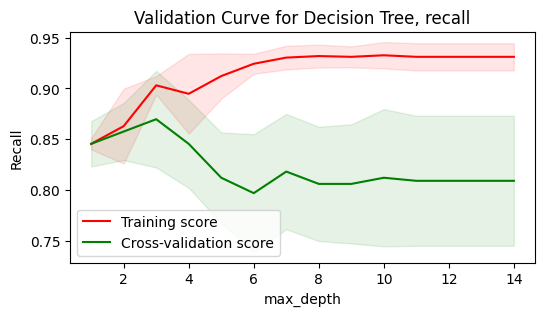

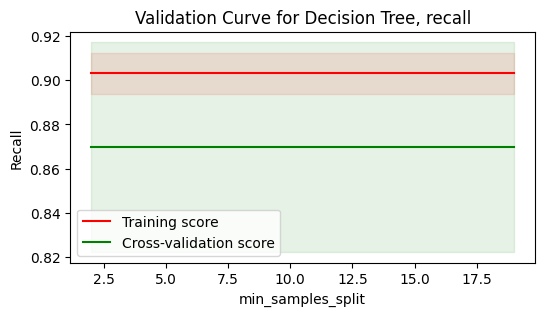

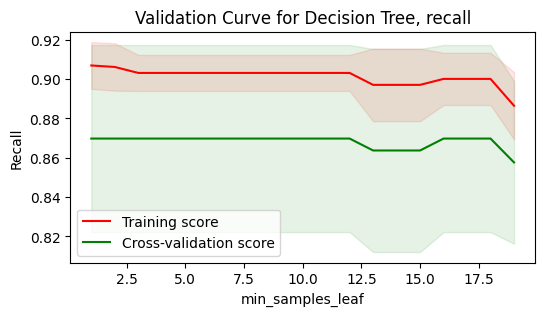

In [20]:
md_range = np.arange(1, 15)
plot_validation_curve('max_depth', md_range)

split_range = np.arange(1, 20)
plot_validation_curve('min_samples_split', split_range)

leaf_range = np.arange(1, 20)
plot_validation_curve('min_samples_leaf', leaf_range)

#### Max Depth
The training score starts low, but approaches 100% as `max_depth` exceeds 7. The cross validation scores reaches peak at `max_depth=3`, before it declines and plateaus at around 5. Beyond `max_depth=3` the model seems to be overfitting. Our choice is therefore justified. 

#### Minimum Split Samples
When fixing `max_depth=3` and `min_saples_leaf=3`, the performance is unaffected by the `min_samples_split` parameter. This justifies the strange results we saw from the grid search. 

### Minimum Leaf Samples
This parameter is also not affecting the performance of the model (when fixing `max_depth` and `min_samples_split`). 

### Conclusion
From the validation curves, it seems that our chosen values of `max_depth=3`, `min_samples_split=5`, `min_samples_leaf=3` is fairly reasonable.